In [1]:
import numpy as np
from numpy.polynomial.hermite_e import hermefit, hermeval
import matplotlib.pyplot as plt

## Fix the function of approximating the conditional extectation

In [2]:
# expand the input X to the hermite series within hermiteOrder
def get_basis(X,hermiteOrder):
    basis = []
    hermiteOrder_matrix = np.identity(hermiteOrder)
    for i in range(hermiteOrder):
        basis.append(hermeval(X, hermiteOrder_matrix[i]))
    return np.array(basis)

# given two vectors X1, X2, and Y, return the coefficients of the vectors of Hermite polynomials expanded by X1 and X2
def fix_coeffsForCondiExp(X1,X2,Y,hermiteOrder):
    A = get_basis(X1,hermiteOrder)
    B = get_basis(X2,hermiteOrder)
    list = []
    for i in range(hermiteOrder):
        for j in range(hermiteOrder):
            list.append(A[i]*B[j])
    XX = np.array(list).T
    beta= np.linalg.lstsq(XX,Y, rcond=None)[0]
    return beta

# Obtaining the conditional Expectation on two input vectors
def fix_approxCondExp(X1,X2,beta,hermiteOrder):
    A = get_basis(X1,hermiteOrder)
    B = get_basis(X2,hermiteOrder)
    list = []
    for i in range(hermiteOrder):
        for j in range(hermiteOrder):
            list.append(A[i]*B[j])
    XX = np.array(list).T
    return XX.dot(beta)

## Set parameters for Merton problem with no consumption for an utility function(log x)

In [3]:
# set the parameters
r = 1/100
u = 3/100
x0 = 1
k = 0.5 #1.5768
theta = 0.2 #0.0398
sigma = 0.2
rou = -0.707
v0 = 0.5

N_mc = 20**2; 
N_basis_f = 3
T = 1 ; N = 100; dt = float(T)/N; t=np.linspace(0,T,N)

epsilon = 10**(-5)##for judging J[i] and J[i+1]
delta = 10**(-4)###for gradient alpha

## initialize needed processes

In [4]:
# This time, we will use two brownion motions for estimating conditional expectation
#  initialize the brownian motion
Wiener1 = np.zeros((N_mc,N))
Wiener2 = np.zeros((N_mc,N))
dW1_df = np.zeros((N_mc,N-1))
dW2_df = np.zeros((N_mc,N-1))
#simuliate the brownian motion & St for N_mc paths
for i in range(N_mc):
    dW1=np.sqrt(dt)*np.random.randn(1,N-1)
    dW1_df[i] = dW1
    W1=np.cumsum(dW1)
    W1=np.insert(W1,0,0)
    Wiener1[i] = W1
    
    dW2=np.sqrt(dt)*np.random.randn(1,N-1)
    dW2_df[i] = dW2
    W2=np.cumsum(dW2)
    W2=np.insert(W2,0,0)
    Wiener2[i] = W2


In [5]:
##initial value for alpha
alpha = np.ones((N_mc,N))
alpha = 0.5 * alpha

In [6]:
v = np.zeros((N_mc,N))
v[:,0] = v0*np.ones(N_mc)
def update_v_merton(v):
    for i in range(1,N):  
        v[:,i] = v[:,i-1] + k*(theta-v[:,i-1])*dt + sigma*np.sqrt(v[:,i-1])*(rou*dW1_df[:,i-1]+np.sqrt(1-rou**2)*dW2_df[:,i-1])            
    return v
v = update_v_merton(v)

In [7]:
X = np.zeros((N_mc,N))
X[:,0] = x0*np.ones(N_mc)
def update_x_merton(X,v,alpha):
    for i in range(1,N):  
        X[:,i] = X[:,i-1] + X[:,i-1]*((u-r)*alpha[:,i-1]+r)*dt + alpha[:,i-1]*X[:,i-1]*np.sqrt(v[:,i-1])*dW1_df[:,i-1]
    return X

In [8]:
#  initialize the simulated Yt process
def update_y_merton(Y_df,X,v,alpha):
    Y_df[:,-1] = np.ones(N_mc)*1/X[:,-1]###utility = log x
    Z_df = np.zeros((N_mc,N-1))

    for i in range(N-2,-1,-1):
        #Simulated Yt process
        # according to the iterative formula, estimate the condition value for Z and simulated Y for each time step
        beta_Z = fix_coeffsForCondiExp(Wiener1[:,i],Wiener2[:,i],Y_df[:,i+1]*dW1_df[:,i],N_basis_f)#(X[:,i],Y_df[:,i+1]*dW1_df[:,i],N_basis_f)
        Z_df[:,i] = fix_approxCondExp(Wiener1[:,i],Wiener2[:,i],beta_Z,N_basis_f)/dt #approxCondExp(X[:,i],beta_Z)/dt

        beta_Y = fix_coeffsForCondiExp(Wiener1[:,i],Wiener2[:,i],Y_df[:,i+1] + ((u-r)*alpha[:,i+1]*Y_df[:,i+1]+
                                                         r*Y_df[:,i+1]+
                                                         alpha[:,i+1]*v[:,i+1]**0.5*Z_df[:,i])*dt,N_basis_f)
       
        
        Y_df[:,i] = fix_approxCondExp(Wiener1[:,i],Wiener2[:,i],beta_Y,N_basis_f)
    return [Y_df,Z_df]


## simulated experiment
Waring! The cell below may take 6-10 minutes to run.

In [9]:
flag = True
count = 0
while flag == True:
    count += 1

    X = update_x_merton(X,v,alpha)
    Y_df = np.zeros((N_mc,N))
    Y = update_y_merton(Y_df,X,v,alpha)[0]
    Z = update_y_merton(Y_df,X,v,alpha)[1]

    for i in range(N-1):## by setting, alpha does not vary among different paths, since it does not control diffusion term.
        alpha[:,i] = alpha[:,i] + delta*(X[:,i]*(u-r)* Y[:,i]+X[:,i]*np.sqrt(v[:,i])*Z[:,i])
                                  #delta * ((mu - r) * X[:,i] * Y[:,i] + X[:,i] * np.sqrt(V[:,i]) * Z[:,i])
    P_J = 0
    for path in range(N_mc):
        P_J += np.log(X[path][-1])
    P_J = P_J / N_mc

    if count == 1:
        J = P_J
        #print(X[0])
        continue

    if J + epsilon > P_J:
        flag = False
        print("solution convergent")
        print([P_J,J])
    elif P_J < J:
        flag = False
        print("Failed")
        print([P_J,J])
    if count > 100000:
        print('Too many iterations')
        break

    J = P_J


print(count)

solution convergence
[0.08409912759953929, 0.08408937356642447]
1292


## plot our strategy

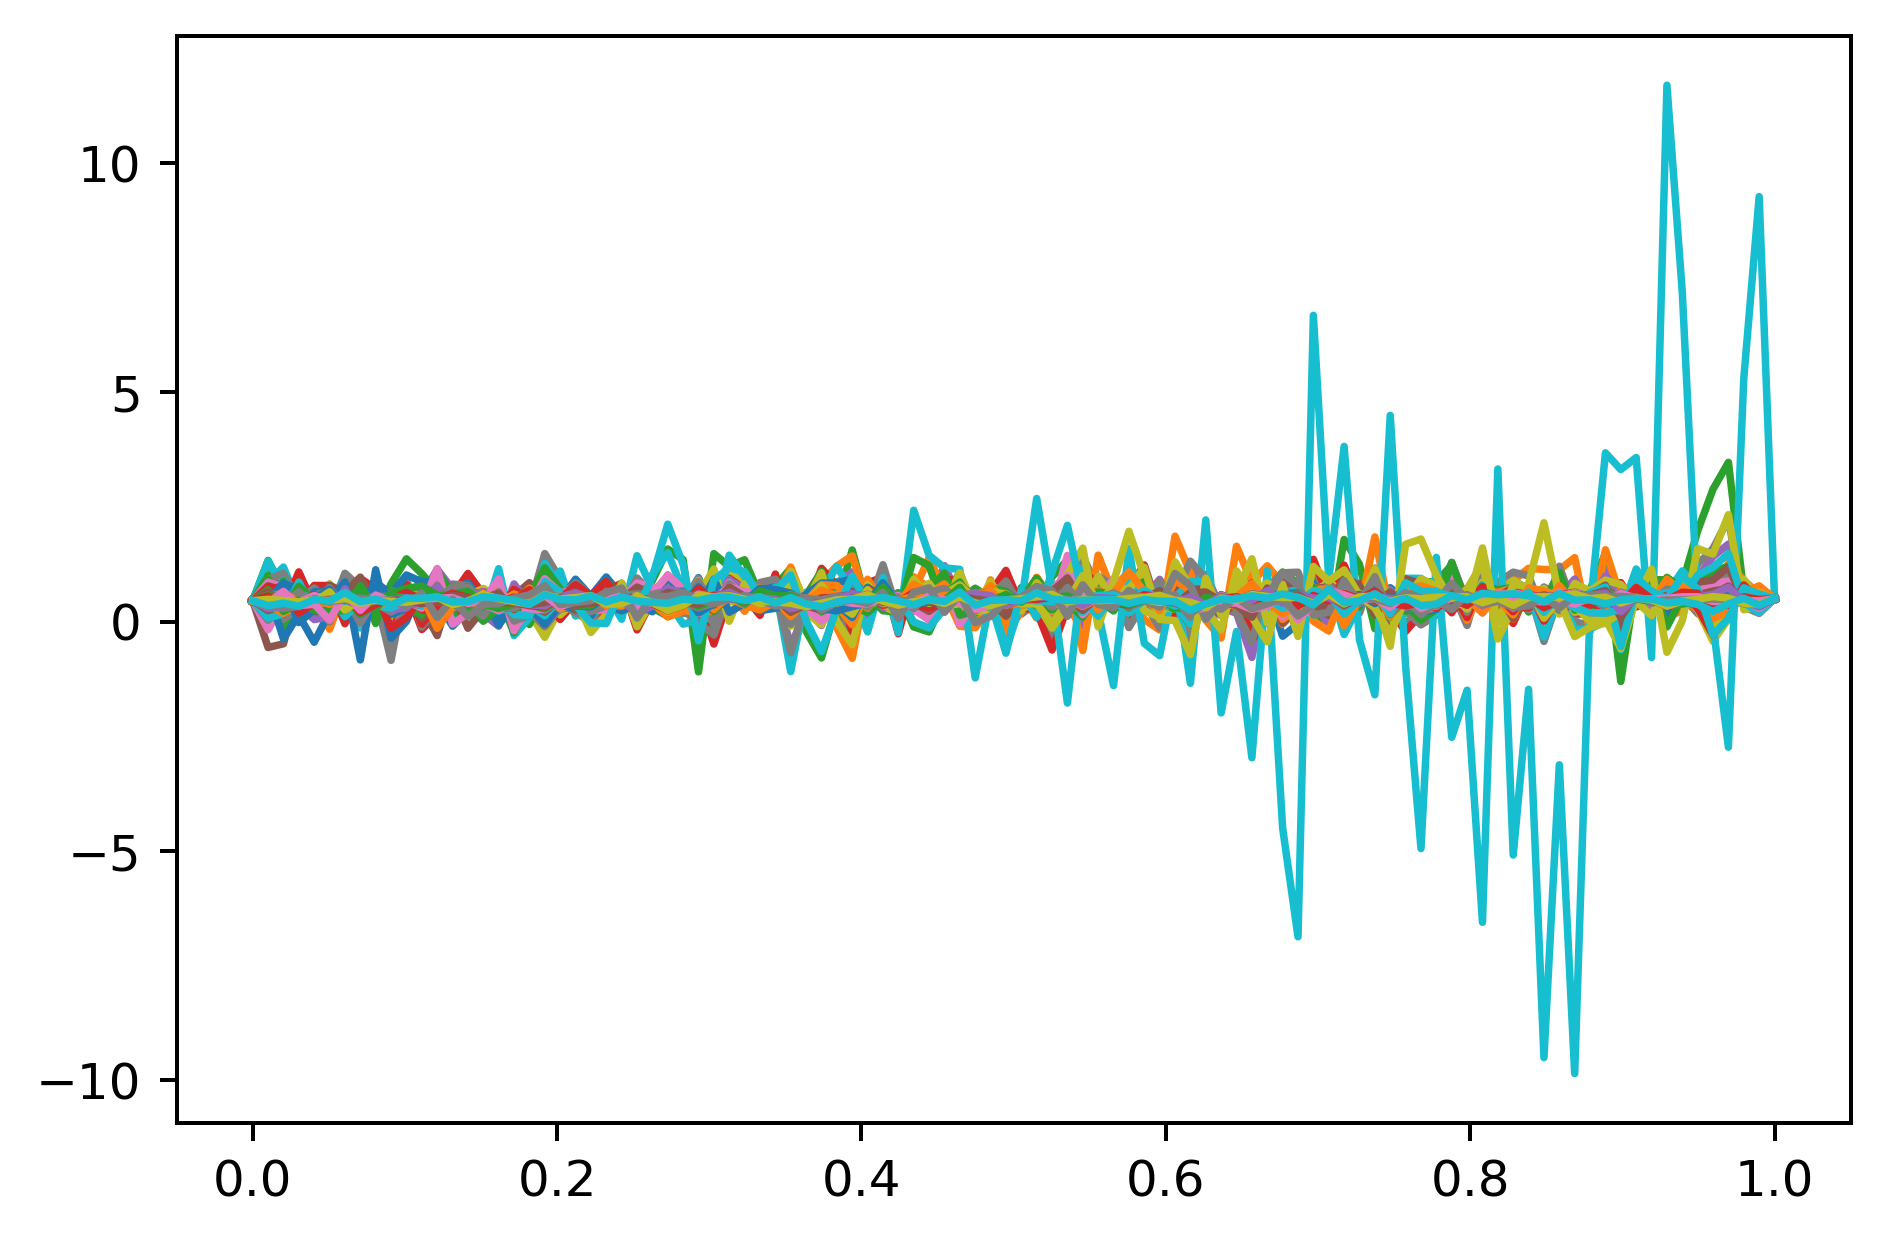

In [10]:
plt.figure(dpi=360)
for i in range(N_mc):
    plt.plot(t,alpha[i])

We generate 400 paths, based on which we estimate the conditional expectation for Y and Z at each time step.  By following the rules of updating J using a log utility function, the solution eventually converge and we get optimal strategies i.e. our proportion of wealth in risky asset for each path shown in the above graph. 